In [1]:
!cd /content && git clone https://github.com/Weff24/SmileMe.git

Cloning into 'SmileMe'...
remote: Enumerating objects: 34176, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 34176 (delta 31), reused 42 (delta 10), pack-reused 34105
Receiving objects: 100% (34176/34176), 88.45 MiB | 18.65 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (107692/107692), done.


/content/SmileMe
Using device:  cuda
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Target label:  neutral


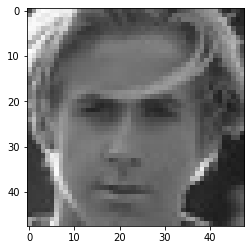

epoch:  1
Iteration 0, loss = 2.4938
Checking accuracy on validation set
Got 907 / 7066 correct (12.84)

Iteration 100, loss = 1.7960
Checking accuracy on validation set
Got 2331 / 7066 correct (32.99)

Iteration 200, loss = 1.4644
Checking accuracy on validation set
Got 2636 / 7066 correct (37.31)

Iteration 300, loss = 1.7121
Checking accuracy on validation set
Got 2987 / 7066 correct (42.27)

Iteration 400, loss = 1.6300
Checking accuracy on validation set
Got 3308 / 7066 correct (46.82)

epoch:  2
Iteration 0, loss = 1.2174
Checking accuracy on validation set
Got 3421 / 7066 correct (48.41)

Iteration 100, loss = 1.1797
Checking accuracy on validation set
Got 3206 / 7066 correct (45.37)

Iteration 200, loss = 1.3264
Checking accuracy on validation set
Got 3339 / 7066 correct (47.25)

Iteration 300, loss = 1.3537
Checking accuracy on validation set
Got 3680 / 7066 correct (52.08)

Iteration 400, loss = 1.2696
Checking accuracy on validation set
Got 3134 / 7066 correct (44.35)

epoch

In [2]:
%cd /content/SmileMe/

import torch
import torch.nn as nn                   #for sequence api in torch
from torch.utils.data import DataLoader #for loading images
import numpy as np                      #just in case if you need numpy arrays
import torchvision.transforms as transforms           #Used for data preprocessing and converting images to tensors
import torchvision.datasets as datasets
import torch.optim                      #For using the desired parameter update
import torch.nn.functional

import matplotlib.pyplot as plt
import random

# check and set device
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print("Using device: ", device)

num_pixels = 48

# preprocessing
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.Resize((num_pixels,num_pixels)), transforms.ToTensor()])
train_data = datasets.ImageFolder("images/train", transform=transform) # is it imagefolder? imagenet?
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True)
validation_data = datasets.ImageFolder("images/validation", transform=transform)
loaded_validation = DataLoader(validation_data,batch_size=64, shuffle=True)
print(train_data.classes)
print(validation_data.classes)

loss_history = []
validation_acc = []
training_acc = []

# visualizing some sample data
dataiter = iter(loaded_train)   #The iter() function in python represents the iterator similar to c++ iterators
images, labels = next(dataiter) #The next() method retrieves the object 
expression = {0:"angry",1:"disgust",2:"fear",3:"happy",4:"neutral",5:"sad",6:"surprise"} #Create a dictionary for mapping accordingly
random_idx = random.sample(range(0,64),1)[0]     #Selects a random single number from 0-64
print("Target label: ",expression[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
plt.imshow(np.transpose(images[random_idx].numpy(), (1, 2, 0)))
plt.show()

# function to check accuracy of model
def check_accuracy_part(loader, model):
    print('Checking accuracy on validation set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

# function to train the model
def train_part(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print("epoch: ",e+1)
        for t, (x, y) in enumerate(loaded_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = torch.nn.functional.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(loaded_validation, model)
                print()

# Actually construct the model
model = None
optimizer = None

#First architecture #3,32,32
conv1 = nn.Sequential(
    nn.Conv2d(3,512,kernel_size=(3,3),bias=True,padding=1), #512,48,48
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))  #Sampling image to half  512,24,24
)
conv2 = nn.Sequential(
    nn.Conv2d(512,128,kernel_size=(3,3),padding=1,bias=True), #128,24,24
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))         #128,12,12
)
conv3 = nn.Sequential(
    nn.Conv2d(128,64,kernel_size=(3,3),bias=True,padding=1), #64,12,12
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))   #64,6,6
)
conv4 = nn.Sequential(
    nn.Conv2d(64,256,kernel_size=(3,3),bias=True,padding=1), #64,6,6
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))   #256,3,3
)
fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*3*3,7),
)
model = nn.Sequential(
    conv1,
    conv2,
    conv3,
    conv4,
    fc
)
learning_rate=0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
train_part(model, optimizer, epochs=10)

# get the best model
best_model = model
check_accuracy_part(loaded_validation,best_model)